# RNN Pseudocode

Given : 

1. Wxh - input to hidden weight
2. Whh - hidden to hidden weight
3. bh - hidden bias
4. Wo - hidden to output weight
5. bo - output bias
6. X - TxD input matrix

<br>

__tanh hidden__ activation<br>
__softmax output__ activation

```python
Yhat = []
h_last = h0
for t in range(T):
    h_t = tanh(X[t].dot(Wx) + h_last.dot(Wh) + bh)
    yhat = softmax(h_t.dot(Wo) + bo)
    yhat.append(yhat)
    
    # important, don't forget to udpate h_last
    h_last = h_t
```

## Steps
1. Load in the data
    - Same as before, but not the right shape for our RNN (N x T x D)
2. Build the model
3. Train the model
4. Evaluate the model
5. Make Predictions

### Building the model
```python
class SimpleRNN(nn.Module):
    def __init__(self, ...):
        self.rnn = nn.RNN(
            input_size=num_inputs,
            hidden_size=num_hidden,
            num_layers=num_layers,
            nonliniearity='relu',
            batch_first=True)
```

In [74]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

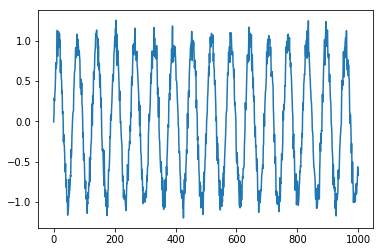

In [75]:
N = 1000
series = np.sin(0.1 * np.arange(N)) + np.random.randn(N) * 0.1

plt.plot(series)

In [76]:
### Build The Dataset
# Let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series)-T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

In [77]:
np.array(X).shape

(990, 10)

In [78]:
np.array(Y).shape

(990,)

In [79]:
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1,1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10, 1) Y.shape (990, 1)


In [80]:
X[0]

array([[-0.00770698],
       [ 0.08335869],
       [ 0.28833362],
       [ 0.25178874],
       [ 0.3553839 ],
       [ 0.39970953],
       [ 0.53241785],
       [ 0.72984351],
       [ 0.6608755 ],
       [ 0.6946754 ]])

In [81]:
# Set Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [82]:
### Define Simple RNN
class SimpleRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super().__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        # note : batch_first=True
        # applies the convention that our data will be of shape:
        # (num_samples, sequence_length, num_features)
        # rather than
        # (sequence_length, num_samples, num_features)
        self.rnn = nn.RNN(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            nonlinearity='relu',
            batch_first=True
        )
        
        self.fc = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        
        # get RNN unit output
        # out is of size (N, T, M)
        # 2nd return value is hidden states at each hidden layer
        # we don't need those now
        out, _ = self.rnn(X, h0)
        
        # We only want h(T) at the final step
        # N x M -> N x K
        out = self.fc(out[:,-1,:])
        return out

In [83]:
# Initiate the model
model = SimpleRNN(n_inputs=1,n_hidden=5, n_rnnlayers=3, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, num_layers=3, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [84]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [85]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [86]:
X_train.shape

torch.Size([495, 10, 1])

In [87]:
y_train.shape

torch.Size([495, 1])

In [88]:
X_test.shape

torch.Size([495, 10, 1])

In [89]:
y_train.shape

torch.Size([495, 1])

In [90]:
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

In [91]:
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
    # Storing losses.
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward Pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward Optimization
        loss.backward()
        optimizer.step()
        
        # Save loss
        train_losses[epoch] = loss.item()
        
        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[epoch] = test_loss.item()
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]. Train loss : {loss.item():.3f}. Test loss : {test_loss.item():.3f}')
            

    return train_losses, test_losses

In [92]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test)

Epoch [5/200]. Train loss : 0.500. Test loss : 0.506
Epoch [10/200]. Train loss : 0.484. Test loss : 0.490
Epoch [15/200]. Train loss : 0.454. Test loss : 0.453
Epoch [20/200]. Train loss : 0.379. Test loss : 0.363
Epoch [25/200]. Train loss : 0.247. Test loss : 0.228
Epoch [30/200]. Train loss : 0.190. Test loss : 0.187
Epoch [35/200]. Train loss : 0.154. Test loss : 0.161
Epoch [40/200]. Train loss : 0.123. Test loss : 0.127
Epoch [45/200]. Train loss : 0.097. Test loss : 0.099
Epoch [50/200]. Train loss : 0.079. Test loss : 0.080
Epoch [55/200]. Train loss : 0.065. Test loss : 0.066
Epoch [60/200]. Train loss : 0.054. Test loss : 0.055
Epoch [65/200]. Train loss : 0.047. Test loss : 0.048
Epoch [70/200]. Train loss : 0.040. Test loss : 0.041
Epoch [75/200]. Train loss : 0.035. Test loss : 0.036
Epoch [80/200]. Train loss : 0.031. Test loss : 0.032
Epoch [85/200]. Train loss : 0.029. Test loss : 0.029
Epoch [90/200]. Train loss : 0.026. Test loss : 0.027
Epoch [95/200]. Train loss : 

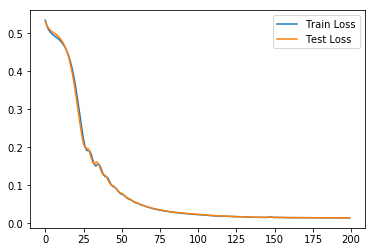

In [93]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

In [94]:
# "Wrong" forecast using true target
validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].reshape(1, T, 1)
    p = model(input_)[0,0].item()
    i += 1
    
    # Update the prediction list
    validation_predictions.append(p)

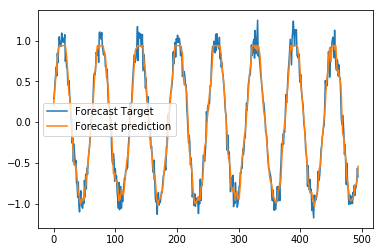

In [95]:
plt.plot(validation_target, label='Forecast Target')
plt.plot(validation_predictions, label='Forecast prediction')
plt.legend()
plt.show()

In [96]:
validation_target = Y[-N//2:]
validation_predictions = []

last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1,T,1)
    p = model(input_)
    # [0, 0]. 1 x 1 array -> scalar
    
    # Update the prediction list
    validation_predictions.append(p[0,0].item())
    
    last_x = torch.cat((last_x[1:], p[0]))

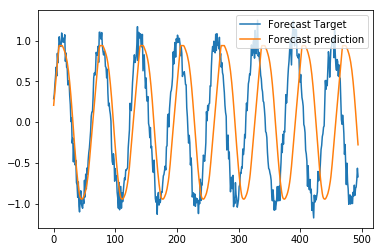

In [97]:
plt.plot(validation_target, label='Forecast Target')
plt.plot(validation_predictions, label='Forecast prediction')
plt.legend()
plt.show()

In [101]:
X_test.shape

torch.Size([495, 10, 1])

In [104]:
X_test.size(0)

495